# Sanctuary Animal Outcome Prediction

Classification task, predicting the outcome of animals that enter the Austin animal sanctuary.
The resulting model may require fine-tuning to be applicable to other areas.

The data is available here: https://www.kaggle.com/c/shelter-animal-outcomes/overview

Note that there is data leakage present, so it is necessary to remove the data that would not typically be present before an outcome has been reached for an animal.

Other than predicting the outcome, interesting questions that could be asked are:

 - What is the expected length of stay?
     - This may help the operations of the sanctuary
 - What are the determining factors for outcome prediction?
     - If there is regional disparity, then regional transfer may improve the likelihood of a positive outcome.
 

In [1]:
# download the data

# !pip install kaggle
# os.environ['KAGGLE_USERNAME'] = "caldweln"
# os.environ['KAGGLE_KEY'] = "4301e905e52fe74537e6e0ad9209b708"
# !kaggle datasets download -d aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes
# !unzip ./austin-animal-center-shelter-intakes-and-outcomes.zip && rm austin-animal-center-shelter-intakes-and-outcomes.zip

In [2]:
# import library modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from catboost.utils import eval_metric
from catboost import CatBoostClassifier, Pool
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score
import scikitplot as skplt

In [3]:
# load the data

df = pd.read_csv('aac_intakes_outcomes.csv')
df.head()

age_upon_outcome animal_id_outcome        date_of_birth outcome_subtype  \
0         10 years           A006100  2007-07-09 00:00:00             NaN   
1          7 years           A006100  2007-07-09 00:00:00             NaN   
2          6 years           A006100  2007-07-09 00:00:00             NaN   
3         10 years           A047759  2004-04-02 00:00:00         Partner   
4         16 years           A134067  1997-10-16 00:00:00             NaN   

      outcome_type sex_upon_outcome  age_upon_outcome_(days)  \
0  Return to Owner    Neutered Male                     3650   
1  Return to Owner    Neutered Male                     2555   
2  Return to Owner    Neutered Male                     2190   
3         Transfer    Neutered Male                     3650   
4  Return to Owner    Neutered Male                     5840   

   age_upon_outcome_(years) age_upon_outcome_age_group     outcome_datetime  \
0                      10.0                (7.5, 10.0]  2017-12-07 14:07:00   
1                       7.0                 (5.0, 7.5]  2014-12-20 16:35:00   
2                       6.0                 (5.0, 7.5]  2014-03-08 17:10:00   
3                      10.0                (7.5, 10.0]  2014-04-07 15:12:00   
4                      16.0               (15.0, 17.5]  2013-11-16 11:54:00   

   ...  age_upon_intake_age_group      intake_datetime intake_month  \
0  ...                (7.5, 10.0]  2017-12-07 00:00:00           12   
1  ...                 (5.0, 7.5]  2014-12-19 10:21:00           12   
2  ...                 (5.0, 7.5]  2014-03-07 14:26:00            3   
3  ...                (7.5, 10.0]  2014-04-02 15:55:00            4   
4  ...               (15.0, 17.5]  2013-11-16 09:02:00           11   

  intake_year  intake_monthyear  intake_weekday  intake_hour  intake_number  \
0        2017           2017-12        Thursday           14            1.0   
1        2014           2014-12          Friday           10            2.0   
2        2014           2014-03          Friday           14            3.0   
3        2014           2014-04       Wednesday           15            1.0   
4        2013           2013-11        Saturday            9            1.0   

             time_in_shelter time_in_shelter_days  
0  0 days 14:07:00.000000000             0.588194  
1  1 days 06:14:00.000000000             1.259722  
2  1 days 02:44:00.000000000             1.113889  
3  4 days 23:17:00.000000000             4.970139  
4  0 days 02:52:00.000000000             0.119444  

[5 rows x 41 columns]

In [4]:
# columns with 'outcome' is data leakage, let's remove with some others too

outcome_cols = [col for col in df.columns if 'outcome' in col.lower()]
features = list(set(df.columns) 
                - set(outcome_cols) 
                - set(['count','intake_number','time_in_shelter','time_in_shelter_days']))

num_cols_mask = np.array(list(map(pd.api.types.is_numeric_dtype, df[features].dtypes.values)) )
cat_features = df[features].columns[~num_cols_mask].values
target = "outcome_type"

feature_df = df[features]
target_df = df[target]

print(f"Starting with the following features: \n{features}\n")
print(f"Where the following are categorical: \n{cat_features}\n")

Starting with the following features: 
['breed', 'dob_monthyear', 'intake_year', 'intake_type', 'intake_month', 'dob_year', 'found_location', 'intake_datetime', 'age_upon_intake_age_group', 'date_of_birth', 'sex_upon_intake', 'animal_id_intake', 'intake_hour', 'age_upon_intake_(years)', 'dob_month', 'intake_weekday', 'animal_type', 'intake_condition', 'age_upon_intake_(days)', 'age_upon_intake', 'intake_monthyear', 'color']

Where the following are categorical: 
['breed' 'dob_monthyear' 'intake_type' 'found_location' 'intake_datetime'
 'age_upon_intake_age_group' 'date_of_birth' 'sex_upon_intake'
 'animal_id_intake' 'intake_weekday' 'animal_type' 'intake_condition'
 'age_upon_intake' 'intake_monthyear' 'color']



In [5]:
# can we drop any useless columns?

feature_df = feature_df[feature_df.columns[(feature_df.notna().sum() / len(feature_df)) > 0.5]]

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
if num_cols_mask.sum() != sel.fit_transform(feature_df[feature_df.columns[num_cols_mask]]).shape[1]:
    print("some feature variance is low enough to remove")



In [6]:
# can we remove rows with NA, but keep 95%

na_rows = feature_df.isna().any(axis=1) | target_df.isna() #.any(axis=1)
na_row_count = na_rows.sum()
if na_row_count < len(feature_df) * 0.05:
    feature_df = feature_df[~na_rows]
    target_df = target_df[~na_rows]
    print(f"{na_row_count} from {len(feature_df)} NA rows removed.")
else:
    print(f"{na_row_count} NAs still exist, but dropna is too crude.")

11 from 79661 NA rows removed.


<AxesSubplot:>

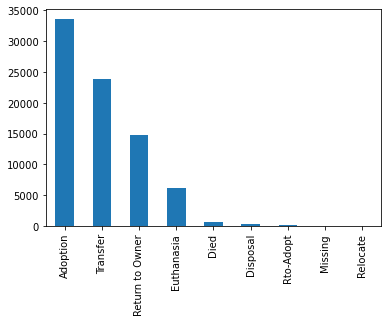

In [7]:
# how is the cardinality and balance?

target_df.value_counts().plot.bar()

# hmmm, not very balanced at all, maybe worth revisiting this
# also only looking at target here, need to inspect features too!!

In [22]:
# data split for train, validation and test

X = feature_df
y = target_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(f"data split: {len(X_train)/len(X):.2f}/{len(X_val)/len(X):.2f}/{len(X_test)/len(X):.2f}")

data split: 0.60/0.20/0.20


In [19]:
# let's train

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(X_val, label=y_val, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

# simple grid to start, let's revisit this 
grid_search = {'lr': [1,0.3,0.1,0.03,0.01]}

for lr in grid_search['lr']:
    model = CatBoostClassifier(iterations=100,
                               learning_rate=lr,
                               depth=5,
                               loss_function='MultiClass',
                               train_dir=f"learing_rate_{lr}") #n_estimators

    model.fit(
        train_pool,
        eval_set=val_pool,
        verbose=False,
        plot=True
    )
    model.save_model(f"outcome_type_lr_{lr}.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
# let's view all at once

train_dirs = [f"learing_rate_{lr}" for lr in grid_search['lr']]
MetricVisualizer(train_dirs).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
best_model = CatBoostClassifier().load_model("outcome_type_lr_0.3.cbm")

In [27]:
# how'd we do?

print('Tree count: ' + str(best_model.tree_count_))
preds_class = best_model.predict(test_pool)
print( f"Accuracy: {accuracy_score(y_test.values, preds_class):.2f}")

Tree count: 100
Accuracy: 0.70


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

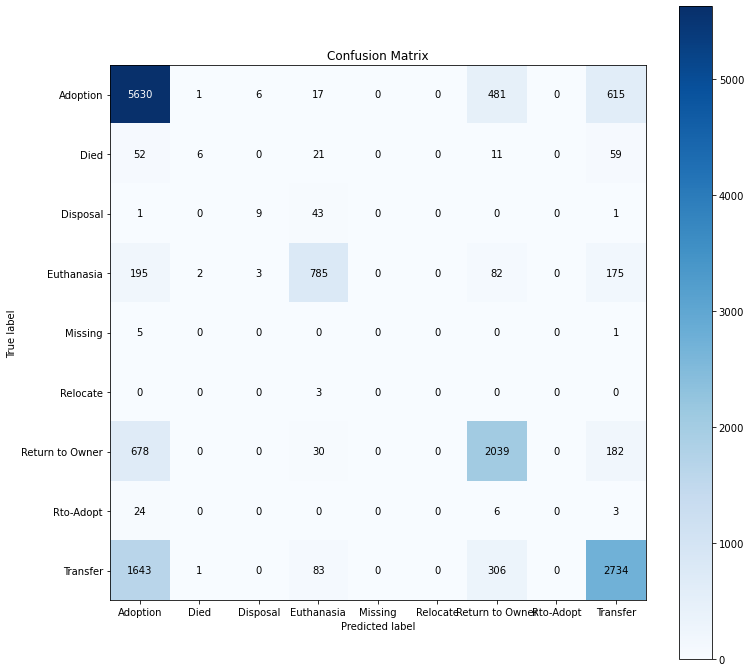

In [28]:
# any classes particularly challenging?

skplt.metrics.plot_confusion_matrix(
    y_test, 
    preds_class,
    figsize=(12,12))

Probabilities for outcome 0: Adoption


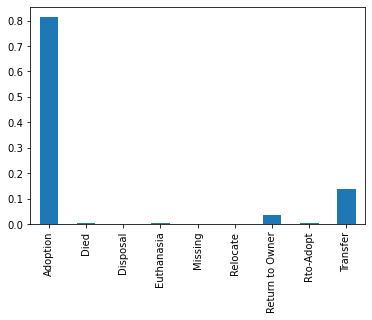

Probabilities for outcome 1: Transfer


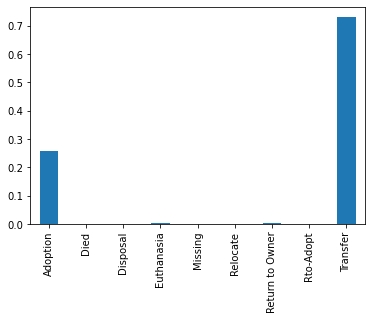

Probabilities for outcome 2: Adoption


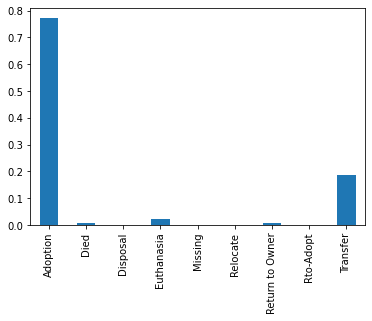

Probabilities for outcome 3: Transfer


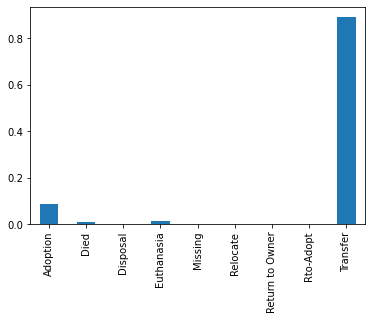

Probabilities for outcome 4: Adoption


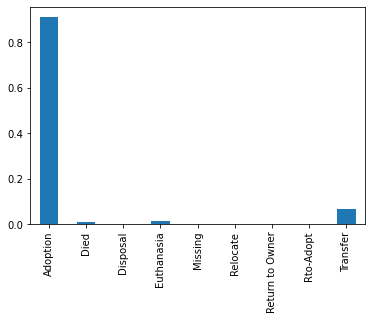

Probabilities for outcome 5: Euthanasia


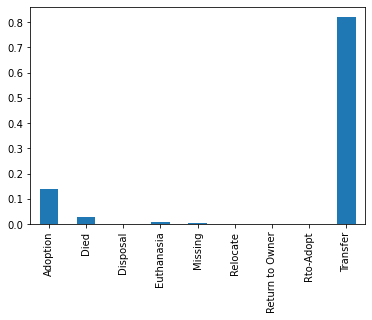

Probabilities for outcome 6: Return to Owner


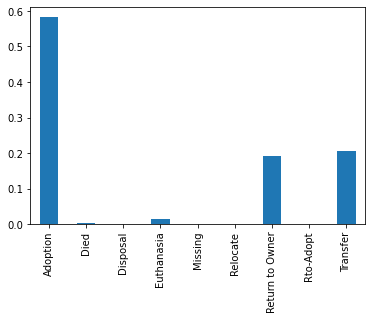

Probabilities for outcome 7: Adoption


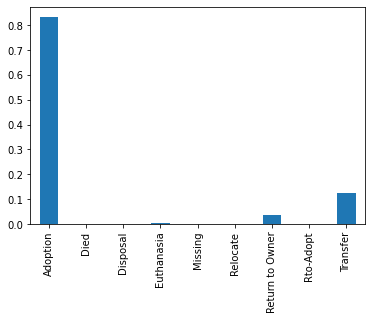

Probabilities for outcome 8: Transfer


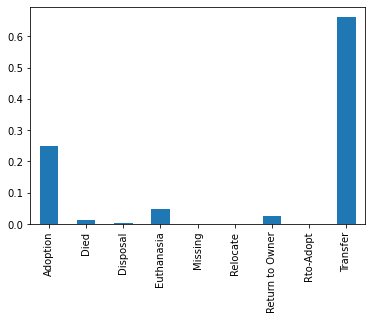

Probabilities for outcome 9: Transfer


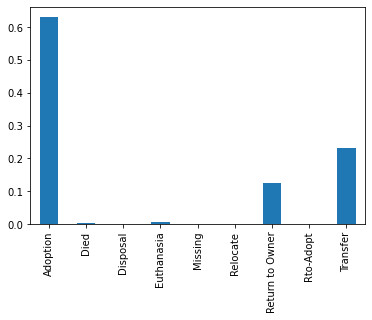

In [29]:
# let's examine some of the prediction probabilities

preds_proba = best_model.predict_proba(test_pool)
df_test_probabilities = pd.DataFrame(preds_proba, columns=sorted(list(y_train.unique())))

for i in range(10):
    print(f"Probabilities for outcome {i}: {y_test.iloc[i]}")
    df_test_probabilities.loc[i].plot.bar()
    plt.show()
    

In [16]:
# what features were decisive?

feature_importances = best_model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

intake_type: 16.221948455777603
sex_upon_intake: 12.31766137967229
intake_datetime: 11.815348999984872
animal_type: 10.183297056204873
age_upon_intake: 7.646258973143608
breed: 6.655694419760896
dob_monthyear: 6.08561970047915
animal_id_intake: 3.9021281538637824
intake_year: 3.39578406310879
found_location: 3.111536335650346
intake_monthyear: 3.0875768472734744
intake_month: 2.855941599840939
intake_condition: 2.795484513140158
age_upon_intake_(days): 2.0834933230608215
date_of_birth: 1.7992782179815192
color: 1.4739611346351664
dob_year: 1.1898397821294489
age_upon_intake_age_group: 0.9360786660589296
age_upon_intake_(years): 0.848235861291467
intake_hour: 0.8407818797460119
dob_month: 0.6629775253317755
intake_weekday: 0.09107311186399349
